# Tutorial 4. A Simple Toy Regression

这是一个快速示例，说明如何使用[教程2：基础知识]（https://github.com/JackKuo666/csdn/tree/master/caffe2） 中介绍的概念进行回归(Regression)。本教程分为两部分。 **第一部分**是创建和训练多项式回归(Polynomial Regression)模型的更详细的例子，**第二部分**是一个简洁的线性回归(Linear Regression)实例。

## Part I: 多项式回归(Polynomial Regression)

我们正在处理的问题是一个相对简单的问题，涉及一维输入$x$和一维输出$y$。因为我们寻找二阶多项式(second order polynomial)作为回归模型(regression model)，权重向量将包含两个权重（$\beta_2$和$\beta_1$）并且会有一个偏差（$\beta_0$)或截距(intercept)。所需的解决方案形式如下：
$$y = \beta_2x^2 + \beta_1x + \beta_0$$

在本教程中，我们将生成并格式化具有强二阶多项式关系的任意输入数据集。然后我们将构建模型，指定训练算法，执行训练，最后查看结果。

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from caffe2.python import workspace, brew, optimizer
from caffe2.python.model_helper import ModelHelper
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.preprocessing import PolynomialFeatures

### Inputs

在此指定回归模型的输入参数包括：输入数据中的样本数(num_samples)，训练迭代次数(training_iters)，SGD算法的学习率(learning_rate)以及模型的初始权重(initial_weights)


In [15]:
# Number of training sample to generate
num_samples = 200
# Learning Rate of SGD algorithm
learning_rate = .05
# Number of iterations to train
training_iters = 100
# Initial model weights
initial_weights = [0.,0.]

### Create and Prepare the Dataset


现在，我们将创建并准备用于模型的数据集。注意，我们只是在这里构建numpy数组。可以使用任何其他数据，只要它在输入到模型之前被正确地整形。

X Sample:
[[ 0.09209892  0.00848221]
 [ 1.15269589  1.32870782]
 [-0.21286333  0.0453108 ]
 [ 0.27024664  0.07303325]
 [ 1.63132252  2.66121316]]
Y Sample:
[[0.59521509]
 [1.87600946]
 [0.2563054 ]
 [0.67216029]
 [3.59454641]]


Text(0.5,1,u'Input Training Data')

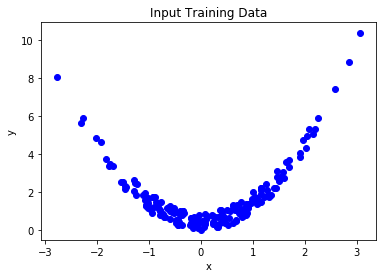

In [42]:
# Create the original observations
orig_X,_ = sklearn.datasets.make_regression(n_samples=num_samples,n_features=1,noise=5)

poly = PolynomialFeatures(degree=2, include_bias=False)
# Transform the features into second order polynomial features
xx_ = poly.fit_transform(orig_X)

# 查看origin_X和xx_的shape以及里边数据的情况======
#print (orig_X.shape)
#print(orig_X[0])
#print(orig_X[0]**2)
#print(xx_.shape)
#print(xx_[0])
#==============================================


# Extract the predictors and the values from the manufactured data
# 从制造的数据中提取预测变量和值
X = [i[0] for i in xx_]
Y_gt = [i[1] for i in xx_]
noise = np.random.uniform(size=(len(Y_gt)))
# Add some noise to the ground truth values
Y_gt += noise



#查看X和Y_gt的shape和数据情况==================
#print(len(X))
#print(X[0])
#print(len(Y_gt))
#print(noise[0])
#print(Y_gt[0])
#============================================


# Shape the ground truth values for use with the model
Y_gt = np.reshape(Y_gt,(-1,1))
# Format the input features. Recall, we accomplish polynomial regression by
#   including the original and the polynomial version of the predictors
#   as features of the model
X = np.hstack((np.array(X).reshape(-1,1),np.array(X).reshape(-1,1)**2))

# 查看更改shape之后的Y_gt和X的shape和数据情况
#print(orig_X[0]**2)#存的是Y_gt[0]的真值,没有加噪声
#print(len(X))
#print(X[0])       #第二列数据里边存的是Y_gt[0]的真值,没有加噪声
#print(len(Y_gt))
#print(Y_gt[0])
# ===========================================

# Print a sample of the input data. X is the list of 2-feature input observations 
#   and Y is the list of ground truth values associated with each observation
print("X Sample:\n{}".format(X[:5]))
print("Y Sample:\n{}".format(Y_gt[:5]))

# Plot the input data
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Training Data")

### Create the Model

#### 定义模型体系结构

通过创建我们的训练数据和我们的二阶多项式假设，我们现在可以创建一个模型来学习回归线(regression line)。我们将使用“FC”层作为模型的主要组件。由于我们需要两个权重（$\beta_2$和$\beta_1$），我们将输入维度设置为2，因为我们只期望单个定量结果，所以我们的输出维度为1.注意，当使用“FC”层时暗示存在偏差，我们将使用它作为$\beta_0$。



此外，在继续查看此步骤中创建的protobuf之前。第一个打印输出是'net'，包含模型的体系结构。乍看之下，我们看到正如预期的那样，网络中有一个操作符`operator` 需要输入$X$,权重$a$和偏差$b$，并输出$y_{pred}$。在打印出'param_init_net'时我们看到这是权重和偏差的初始化存在的地方。这是一个重要的观察结果，可以深入了解如何构建和维护Caffe2中的模型。

In [43]:
# Create the model helper object we will use to create the regression model
regression_model = ModelHelper(name="regression_model")

# Add the FC layer, which is the main component of a linear regression model
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=2, dim_out=1)

# Print the predict and init net to see what protobuf was created for this model
print("************* Predict Net *************")
print(regression_model.net.Proto())
print("\n************* Init Net *************")
print(regression_model.param_init_net.Proto())

************* Predict Net *************
name: "regression_model_2"
op {
  input: "X"
  input: "y_pred_w"
  input: "y_pred_b"
  output: "y_pred"
  name: ""
  type: "FC"
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
external_input: "X"
external_input: "y_pred_w"
external_input: "y_pred_b"


************* Init Net *************
name: "regression_model_init_2"
op {
  output: "y_pred_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 1
    ints: 2
  }
}
op {
  output: "y_pred_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
}



#### Add the training operators and prime(填充) the workspace


在这个**非常重要的**步骤中，我们指定损失函数，设置SGD训练算法，填充和初始化工作空间，并初始化模型的权重和偏差。

In [44]:
# The loss function is computed by a squared L2 distance, 
#   and then averaged over all items.
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Add the gradient operators and setup the SGD algorithm
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=learning_rate)

# Prime the workspace with some data
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))

# Run the init net to prepare the workspace then create the net
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Inject our desired initial weights and bias
workspace.FeedBlob("y_pred_w",np.array([initial_weights]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

True

#### Run the training

In [45]:
# Run the training for training_iters
for i in range(training_iters):
    workspace.RunNet(regression_model.net)

print("Training Complete")

Training Complete


### Extract Results(提取结果)


现在我们的模型已经过训练，我们可以提取在名为“y_pred_w”和“y_pred_b”的工作空间中作为blob存在的学习权重和偏差。

0.45223227
[-0.00435348  1.025054  ]
Best Fit Line: 1.02505*x^2 + -0.00435*x + 0.45223


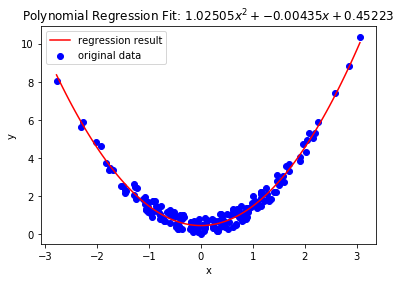

In [60]:
# Extract the learned coes and intercept from the workspace
coes = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# 查看y_preb_w和y_pred_b中存储的参数=======
#print(workspace.FetchBlob("y_pred_w"))
#print(workspace.FetchBlob("y_pred_b"))
#========================================
print(intercept[0])
print(coes)

# Calculate the regression line for plotting
x_vals = np.linspace(orig_X.min(), orig_X.max(),100)
regression_result = intercept[0] + coes[0]*x_vals + coes[1]*(x_vals**2)
print("Best Fit Line: {}*x^2 + {}*x + {}".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))#round(x,5)返回5位精度值

# Plot the results of the regression
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
#plt.plot(x_vals,(x_vals**2),label="result",color='g')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial Regression Fit: ${{{}}}x^2 + {{{}}}x + {{{}}}$".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))
plt.show()


## Part II: 表达线性回归示例(Express Linear Regression Example)


上面的示例显示了如何创建一个易于调整以处理高阶多项式的多项式回归模型。现在，我们将考虑基本情况，我们需要一个简单的一阶模型(first order model)，一维输入$x$，1-D输出$y$，和一个解决方案：

$$y = \beta_1x + \beta_0$$


第二部分的结构与第一部分类似。首先，我们将生成数据集，然后我们将构建模型并指定训练例程，最后我们将训练和提取我们的结果。

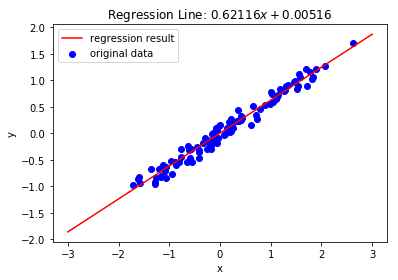

In [61]:
#####################################################################
# Initialize data
#####################################################################
X,Y_gt = sklearn.datasets.make_regression(n_samples=100,n_features=1,noise=10)
Y_gt = np.reshape(Y_gt,(-1,1))
Y_gt /= 100.

#####################################################################
# Create and train model
#####################################################################
# Construct model with single FC layer
regression_model = ModelHelper(name="regression_model")
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=1, dim_out=1)

# Specify Loss function
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Get gradients for all the computations above.
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=0.05)

# Prime and prepare workspace for training
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Set the initial weight and bias to 0
workspace.FeedBlob("y_pred_w",np.array([[0.]]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

# Train the model
for i in range(100):
    workspace.RunNet(regression_model.net)

#####################################################################
# Collect and format results
#####################################################################
# Grab the learned weight and bias from workspace
coe = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# Calculate the regression line for plotting
x_vals = range(-3,4)
regression_result = x_vals*coe + intercept

# Plot the results
plt.scatter(X,Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression Line: ${{{}}}x + {{{}}}$".format(round(coe,5), round(intercept[0],5)))
plt.show()
